In [1]:
# 
import numpy as np 
import pandas as pd 




In [2]:
!pip install textstat

In [3]:
!pip install pyLDAvis

In [2]:
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium 
from folium import plugins 


def plot_readability(a,b,title,bins=0.1,colors=['#3A4750', '#F64E8B']):
    trace1 = ff.create_distplot([a,b], [" Real disaster tweets","Not real disaster tweets"], bin_size=bins, colors=colors, show_rug=False)
    trace1['layout'].update(title=title)
    py.iplot(trace1, filename='Distplot')
    table_data= [["Statistical Measures"," Not real disaster tweets","real disaster tweets"],
                ["Mean",mean(a),mean(b)],
                ["Standard Deviation",pstdev(a),pstdev(b)],
                ["Variance",pvariance(a),pvariance(b)],
                ["Median",median(a),median(b)],
                ["Maximum value",max(a),max(b)],
                ["Minimum value",min(a),min(b)]]
    trace2 = ff.create_table(table_data)
    py.iplot(trace2, filename='Table')

punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [6]:
train['text'] = train['text'].apply(lambda x:cleanhtml(x))
test['text'] = test['text'].apply(lambda x:cleanhtml(x))


train['text'] = train['text'].apply(lambda x:removeurl(x))
test['text'] = test['text'].apply(lambda x:removeurl(x))


In [7]:
cnt_srs = train['target'].value_counts()
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Jet',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Target Count',
    font=dict(size=18)
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="TargetCount")

## target distribution ##
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

In [8]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [9]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [11]:
df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="geopy/1.11.0")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Australia
Chicago, IL
California
California, USA
Everywhere
New York, NY
United Kingdom


In [12]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

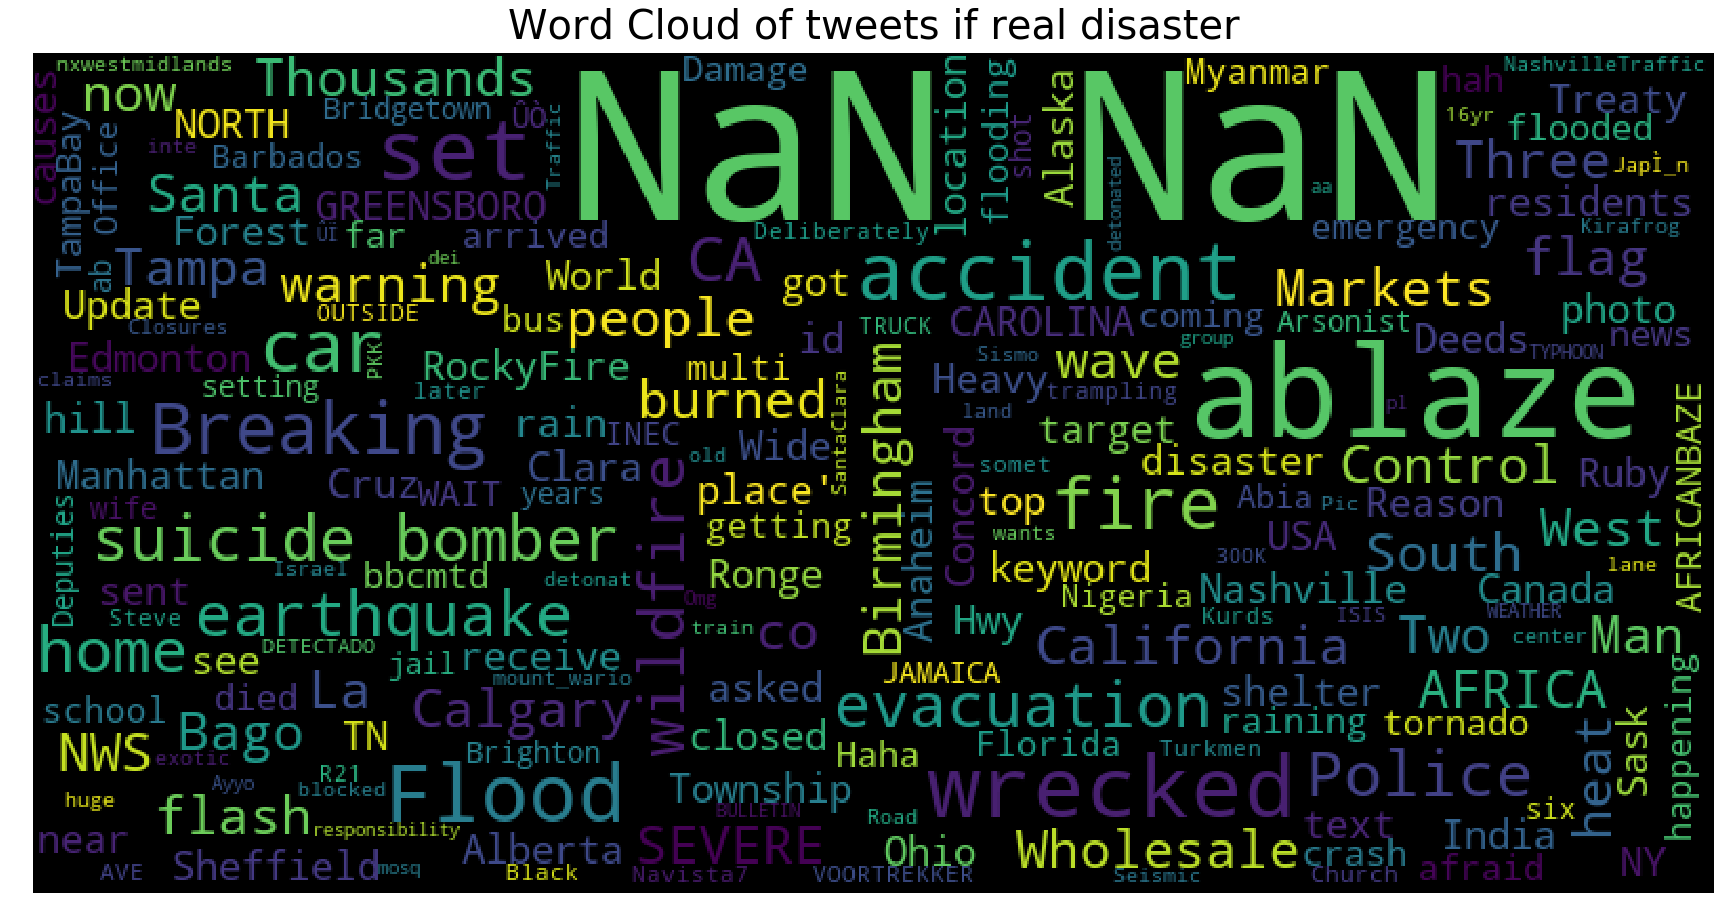

In [13]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train[train["target"]==1], title="Word Cloud of tweets if real disaster")

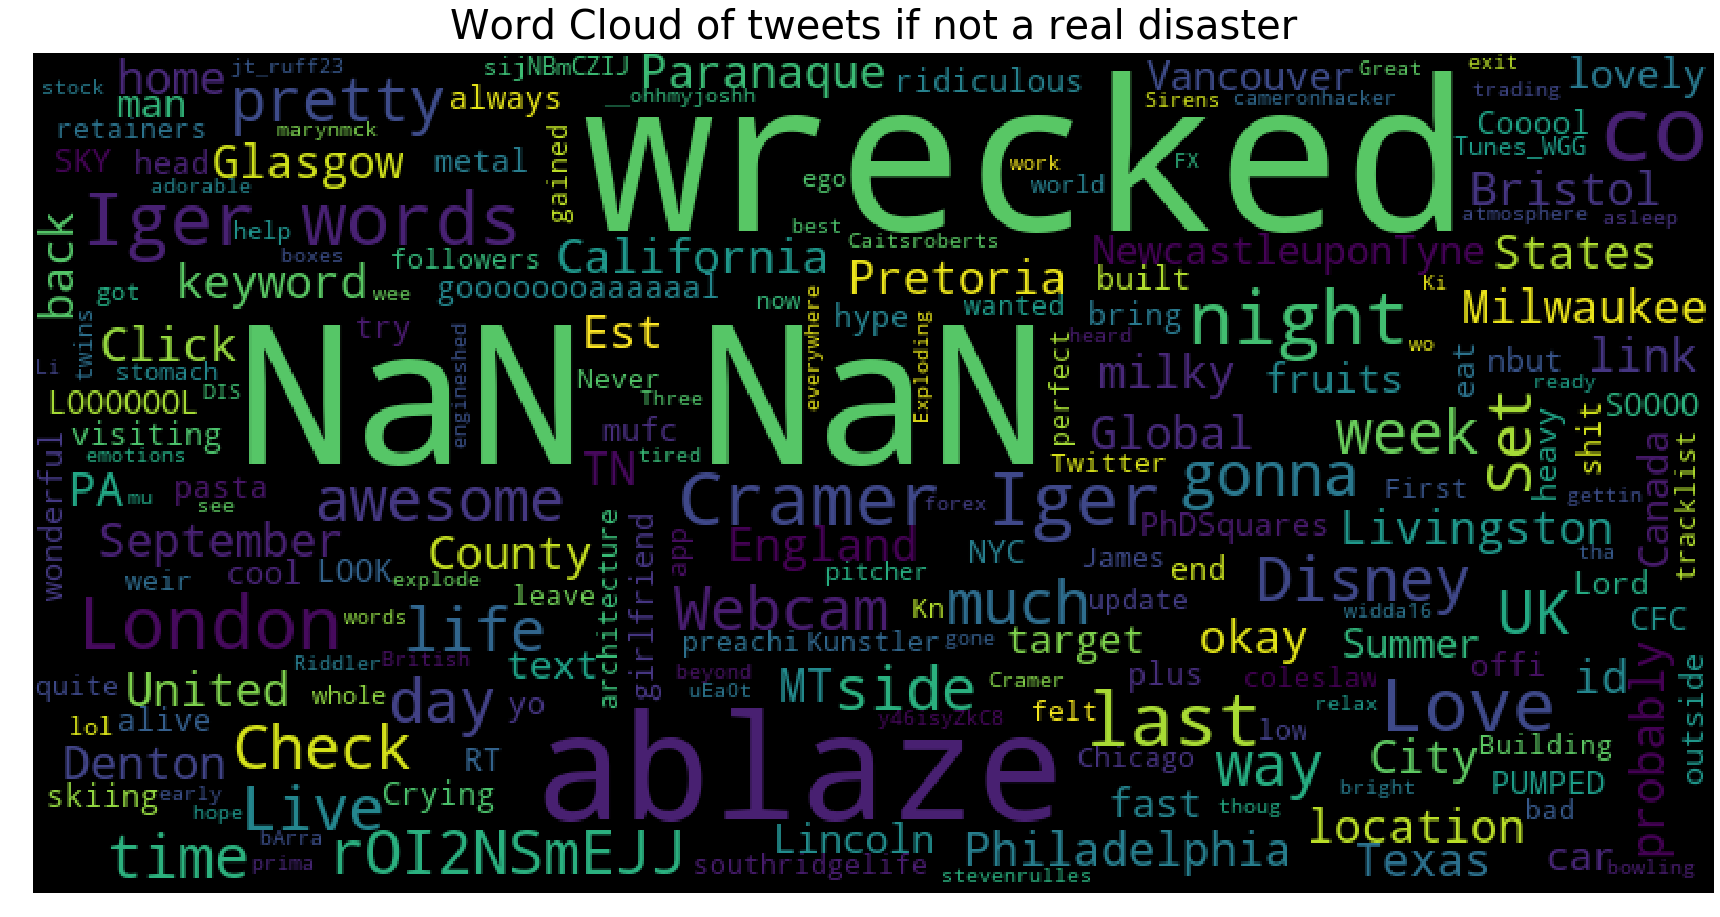

In [14]:
plot_wordcloud(train[train["target"]==0], title="Word Cloud of tweets if not a real disaster")

In [15]:
from collections import defaultdict
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'red')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')



C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [16]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,horizontal_spacing=0.15,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [17]:
freq_dict = defaultdict(int)
for sent in train0_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')


freq_dict = defaultdict(int)
for sent in train1_df["text"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.2,
                          subplot_titles=["Frequent words if tweet is not real disaster", 
                                          "Frequent words if tweet is real disaster"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


C:\Users\Vikrant\Anaconda3\lib\site-packages\plotly\basedatatypes.py:1823: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




In [18]:
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))


train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))


train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))


train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))


train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )


train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

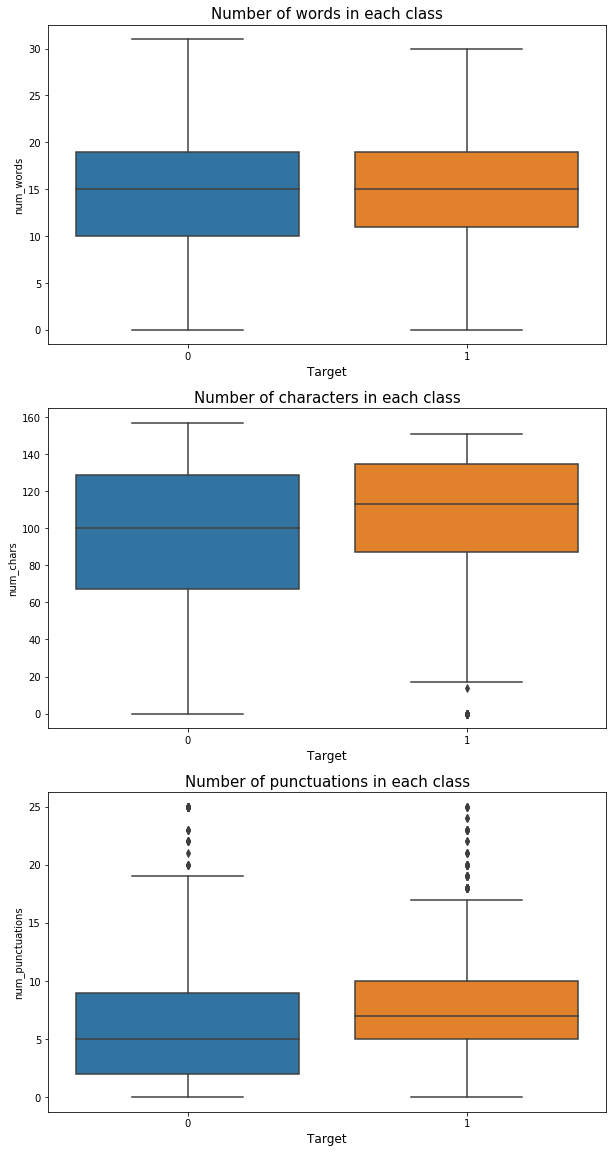

In [19]:
train['num_words'].loc[train['num_words']>60] = 100 #truncation for better visuals
train['num_punctuations'].loc[train['num_punctuations']>25] = 25 #truncation for better visuals
train['num_chars'].loc[train['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='target', y='num_words', data=train, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='target', y='num_chars', data=train, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='target', y='num_punctuations', data=train, ax=axes[2])
axes[2].set_xlabel('Target', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

In [20]:
train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]

fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_words'],name = 'Number of words in tweets about real disaster'))
fig.add_trace(go.Histogram(x=train0_df['num_words'],name = 'Number of words in tweets other than real disaster'))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [21]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(200, 100, 0, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_chars'],name = 'Number of chars in tweets about real disaster',marker = dict(color = 'rgba(25, 133, 120, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train1_df['num_punctuations'],name = 'Number of punctuations in tweets about real disaster',marker = dict(color = 'rgba(97, 175, 222, 0.8)')))
fig.add_trace(go.Histogram(x=train0_df['num_punctuations'],name = 'Number of punctuations in tweets other than real disaster',marker = dict(color = 'rgba(200, 10, 150, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=1)
fig.show()

In [23]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_words'],name = 'Number of words in training tweets',marker = dict(color = 'rgba(255, 0, 0, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_words'],name = 'Number of words in testing tweets ',marker = dict(color = 'rgba(0, 187, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_chars'],name = 'Number of chars in training tweets',marker = dict(color = 'rgba(25, 13, 8, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_chars'],name = 'Number of chars in testing tweets ',marker = dict(color = 'rgba(8, 25, 187, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()
%matplotlib inline

In [25]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=train['num_punctuations'],name = 'Number of punctuations in training tweets',marker = dict(color = 'rgba(222, 111, 33, 0.8)')))
fig.add_trace(go.Histogram(x=test['num_punctuations'],name = 'Number of punctuations in testing tweets ',marker = dict(color = 'rgba(33, 111, 222, 0.8)')))

# Overlay both histograms
fig.update_layout(barmode='stack')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

In [26]:
tqdm.pandas()
fre_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_reading_ease))
fre_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_reading_ease))
plot_readability(fre_notreal,fre_real,"Flesch Reading Ease",20)

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 4645.54it/s]


In [27]:
fkg_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.flesch_kincaid_grade))
fkg_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.flesch_kincaid_grade))
plot_readability(fkg_notreal,fkg_real,"Flesch Kincaid Grade",4,['#C1D37F','#491F21'])

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 8864.19it/s]


In [28]:
fog_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.gunning_fog))
fog_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.gunning_fog))
plot_readability(fog_notreal,fog_real,"The Fog Scale (Gunning FOG Formula)",4,['#E2D58B','#CDE77F'])

100%|█████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:05<00:00, 611.66it/s]


In [29]:
ari_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.automated_readability_index))
ari_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.automated_readability_index))
plot_readability(ari_notreal,ari_real,"Automated Readability Index",10,['#488286','#FF934F'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 27105.74it/s]


In [30]:
cli_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.coleman_liau_index))
cli_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.coleman_liau_index))
plot_readability(cli_notreal,cli_real,"The Coleman-Liau Index",10,['#8491A3','#2B2D42'])

100%|███████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 18634.92it/s]


In [31]:
lwf_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.linsear_write_formula))
lwf_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.linsear_write_formula))
plot_readability(lwf_notreal,lwf_real,"Linsear Write Formula",2,['#8D99AE','#EF233C'])

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:00<00:00, 7022.31it/s]


In [32]:
dcr_notreal = np.array(train["text"][train["target"] == 0].progress_apply(textstat.dale_chall_readability_score))
dcr_real = np.array(train["text"][train["target"] == 1].progress_apply(textstat.dale_chall_readability_score))
plot_readability(dcr_notreal,dcr_real,"Dale-Chall Readability Score",1,['#C65D17','#DDB967'])

100%|█████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:04<00:00, 755.35it/s]


In [33]:
def consensus_all(text):
    return textstat.text_standard(text,float_output=True)

con_notreal = np.array(train["text"][train["target"] == 0].progress_apply(consensus_all))
con_real = np.array(train["text"][train["target"] == 1].progress_apply(consensus_all))
plot_readability(con_notreal,con_real,"Readability Consensus based upon all the above tests",2)

100%|█████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:09<00:00, 333.31it/s]


In [34]:
notreal_text = train["text"][train["target"] == 0].progress_apply(spacy_tokenizer)
real_text = train["text"][train["target"] == 1].progress_apply(spacy_tokenizer)
#count vectorization
vectorizer_notreal = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
notreal_vectorized = vectorizer_notreal.fit_transform(notreal_text)
vectorizer_real = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
real_vectorized = vectorizer_real.fit_transform(real_text)

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<>:4: DeprecationWarning:

invalid escape sequence \-

<>:6: DeprecationWarning:

invalid escape sequence \-

<ipython-input-34-58bf4d331be0>:4: DeprecationWarning:

invalid escape sequence \-

<ipython-input-34-58bf4d331be0>:6: DeprecationWarning:

invalid escape sequence \-

100%|████████████████████████████████████████████████████████████████████████████| 3271/3271 [00:01<00:00, 1948.70it/s]


In [35]:
# Latent Dirichlet Allocation Model
lda_notreal = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
notreal_lda = lda_notreal.fit_transform(notreal_vectorized)
lda_real = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online',verbose=True)
real_lda = lda_real.fit_transform(real_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [36]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [37]:
print("Not real disaster tweets LDA Model:")
selected_topics(lda_notreal, vectorizer_notreal)

Not real disaster tweets LDA Model:
Topic 0:
[('like', 186.94080954395625), ('way', 58.09162114132342), ('best', 54.076371139404756), ('black', 48.939754834894075), ('feel', 45.93626542323662), ('know', 41.52743564865342), ('movie', 35.314469890156424), ('crash', 34.48588011100853), ('little', 32.90705690206354), ('phone', 28.002222189685366)]
Topic 1:
[('https', 243.1517178395173), ('love', 92.27780185144364), ('got', 91.84858267508741), ('day', 66.06561160172498), ('http', 65.56988166336572), ('survive', 37.72676038966571), ('disaster', 33.423901258053775), ('survived', 33.235880422373334), ('soon', 27.958901065117498), ('week', 26.647374021585694)]
Topic 2:
[('time', 85.80829217420022), ('like', 57.90472812722153), ('god', 45.30193674397907), ('right', 43.85468481509567), ('dead', 31.831914699319345), ('zone', 29.905108569265455), ('injury', 29.116682668561964), ('trouble', 27.845197744965862), ('summer', 27.03924231205681), ('twitter', 26.90431980358047)]
Topic 3:
[('man', 63.23617

In [38]:
print("Real disaster tweets LDA Model:")
selected_topics(lda_real, vectorizer_real)

Real disaster tweets LDA Model:
Topic 0:
[('http', 160.27701069901318), ('army', 44.44632265511734), ('terrorism', 37.1679366637516), ('failure', 32.19490857148592), ('massacre', 30.630478388808157), ('hostages', 27.982928928332324), ('iran', 26.1930367087402), ('israeli', 24.218524127218082), ('bodies', 23.11635631710211), ('virgin', 21.951451997176225)]
Topic 1:
[('http', 394.92609487282704), ('suicide', 138.01163344917708), ('news', 95.04836901986297), ('malaysia', 89.42887979933536), ('train', 73.04513147779073), ('investigators', 70.44598690611326), ('crash', 69.12399024945658), ('confirmed', 68.18181322438018), ('dead', 62.93434445494805), ('bombing', 53.60164091944274)]
Topic 2:
[('http', 229.4123015003281), ('people', 98.96155528589424), ('attack', 66.33363001266261), ('world', 46.2499928547797), ('killed', 40.396388617369176), ('injured', 39.79174523175368), ('terrorist', 39.4857770403827), ('police', 38.37885030385767), ('evacuation', 35.82844916773411), ('survivors', 34.8694

In [39]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_notreal, notreal_vectorized, vectorizer_notreal, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8       67.253036  -27.553791       1        1  14.456932
9      263.339111  106.400604       2        1  10.137635
1       72.836189 -265.015930       3        1   9.793598
3       80.296997  208.009003       4        1   9.749621
6     -299.496765  -74.065048       5        1   9.739867
0     -103.396606   59.961773       6        1   9.626005
2      258.407684 -125.639969       7        1   9.571964
4     -116.419983 -175.566086       8        1   9.245614
5     -109.027191  297.366119       9        1   9.044451
7     -294.593933  157.967026      10        1   8.634311, topic_info=     Category         Freq         Term        Total  loglift  logprob
601   Default  1721.000000         http  1721.000000  30.0000  30.0000
602   Default   227.000000        https   227.000000  29.0000  29.0000
710   Default   252.000000         like   252.000000  28.0000  28.0000
29    Default   189.000000          amp   189.000000  27.0000  27.0000
1283  Default    89.000000        video    89.000000  26.0000  26.0000
882   Default    90.000000       people    90.000000  25.0000  25.0000
743   Default    86.000000         love    86.000000  24.0000  24.0000
517   Default    86.000000          got    86.000000  23.0000  23.0000
829   Default   169.000000          new   169.000000  22.0000  22.0000
130   Default    85.000000         body    85.000000  21.0000  21.0000
1211  Default    83.000000         time    83.000000  20.0000  20.0000
1370  Default    74.000000      youtube    74.000000  19.0000  19.0000
381   Default    71.000000    emergency    71.000000  18.0000  18.0000
1356  Default    71.000000        wreck    71.000000  17.0000  17.0000
515   Default    69.000000         good    69.000000  16.0000  16.0000
1196  Default    66.000000        think    66.000000  15.0000  15.0000
830   Default    67.000000         news    67.000000  14.0000  14.0000
728   Default    62.000000          lol    62.000000  13.0000  13.0000
1300  Default    63.000000         want    63.000000  12.0000  12.0000
293   Default    78.000000          day    78.000000  11.0000  11.0000
512   Default    73.000000        going    73.000000  10.0000  10.0000
757   Default    59.000000          man    59.000000   9.0000   9.0000
1311  Default    54.000000          way    54.000000   8.0000   8.0000
701   Default    72.000000          let    72.000000   7.0000   7.0000
95    Default    51.000000         best    51.000000   6.0000   6.0000
966   Default    61.000000       reddit    61.000000   5.0000   5.0000
567   Default    48.000000         help    48.000000   4.0000   4.0000
523   Default    47.000000        great    47.000000   3.0000   3.0000
108   Default    46.000000        black    46.000000   2.0000   2.0000
706   Default    57.000000         life    57.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
72    Topic10    23.839056         baby    24.690621   2.4143  -4.3621
1192  Topic10    24.361291        thank    25.236142   2.4141  -4.3405
708   Topic10    23.176807    lightning    24.028529   2.4133  -4.3903
1200  Topic10    22.491102      thought    23.345156   2.4122  -4.4204
1343  Topic10    21.809862        words    22.662879   2.4111  -4.4511
131   Topic10    21.720947         bomb    22.573297   2.4109  -4.4552
1325  Topic10    21.249358        white    22.102968   2.4100  -4.4771
560   Topic10    20.417918        heart    21.271254   2.4085  -4.5171
79    Topic10    20.006167       banned    20.868349   2.4072  -4.5374
866   Topic10    26.232472  pandemonium    27.583060   2.3992  -4.2665
1246  Topic10    16.449402        truck    17.301277   2.3989  -4.7332
798   Topic10    15.243764          mom    16.095520   2.3951  -4.8093
332   Topic10    14.914757       disney    15.766280   2.3939  -4.8311
824   Topic10    13.867933       nearby    14.720514   2.3898  -4.

In [40]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda_real, real_vectorized, vectorizer_real, mds='tsne')
dash

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1       32.492798 -109.601646       1        1  13.113933
3      -90.670692  -35.199165       2        1  11.741872
8       89.191032  -41.897526       3        1  11.579791
9     -120.834969   38.520580       4        1  10.541163
5      -55.771320 -106.798714       5        1  10.247203
2       59.035370   31.827581       6        1   9.373577
6       24.127201  103.424850       7        1   9.310597
7      -64.137825  106.224983       8        1   9.231487
4      -30.728611   31.613483       9        1   7.909512
0       -0.909830  -34.986706      10        1   6.950863, topic_info=     Category         Freq          Term        Total  loglift  logprob
294   Default   119.000000      disaster   119.000000  30.0000  30.0000
42    Default   111.000000           amp   111.000000  29.0000  29.0000
148   Default   116.000000    california   116.000000  28.0000  28.0000
1023  Default   121.000000       suicide   121.000000  27.0000  27.0000
515   Default  2171.000000          http  2171.000000  26.0000  26.0000
516   Default   106.000000         https   106.000000  25.0000  25.0000
364   Default   103.000000      families   103.000000  24.0000  24.0000
775   Default    97.000000        people    97.000000  23.0000  23.0000
1010  Default    95.000000         storm    95.000000  22.0000  22.0000
608   Default    84.000000          like    84.000000  21.0000  21.0000
1200  Default    90.000000      wreckage    90.000000  20.0000  20.0000
803   Default   114.000000        police   114.000000  19.0000  19.0000
386   Default    80.000000         fires    80.000000  18.0000  18.0000
728   Default    75.000000       nuclear    75.000000  17.0000  17.0000
719   Default   139.000000          news   139.000000  16.0000  16.0000
1139  Default    74.000000         video    74.000000  15.0000  15.0000
1178  Default    74.000000      wildfire    74.000000  14.0000  14.0000
636   Default    79.000000      malaysia    79.000000  13.0000  13.0000
64    Default    64.000000        attack    64.000000  12.0000  12.0000
327   Default    62.000000     emergency    62.000000  11.0000  11.0000
735   Default    60.000000         obama    60.000000  10.0000  10.0000
745   Default    69.000000           old    69.000000   9.0000   9.0000
117   Default    77.000000          bomb    77.000000   8.0000   8.0000
726   Default    64.000000      northern    64.000000   7.0000   7.0000
497   Default    81.000000     hiroshima    81.000000   6.0000   6.0000
599   Default    59.000000  legionnaires    59.000000   5.0000   5.0000
949   Default    56.000000        severe    56.000000   4.0000   4.0000
1156  Default    51.000000       warning    51.000000   3.0000   3.0000
502   Default    58.000000         homes    58.000000   2.0000   2.0000
1088  Default    64.000000         train    64.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
359   Topic10    33.161251       failure    34.128993   2.6375  -3.7627
549   Topic10    26.979231          iran    27.824251   2.6355  -3.9690
649   Topic10    31.549864      massacre    32.613013   2.6332  -3.8125
556   Topic10    24.945452       israeli    25.830673   2.6314  -4.0474
115   Topic10    23.810203        bodies    24.657054   2.6314  -4.0940
417   Topic10    22.056995     fukushima    22.902203   2.6287  -4.1705
509   Topic10    28.822847      hostages    29.931272   2.6286  -3.9029
784   Topic10    21.304394       picking    22.150890   2.6273  -4.2052
1199  Topic10    20.565560         wreck    21.412049   2.6260  -4.2405
1144  Topic10    22.610333        virgin    23.570928   2.6247  -4.1457
421   Topic10    21.217466      galactic    22.195888   2.6212  -4.2093
1189  Topic10    17.504436          work    18.353762   2.6189  -4.4017
691   Topic10    17.286679         mount    18.151791   2.6175  -4.4142
40    Topic10    19.2

In [41]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [42]:
train_y = train["target"].values

def runModel(train_X, train_y, test_X, test_y, test_X2):
    model = linear_model.LogisticRegression(C=5., solver='sag')
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)[:,1]
    pred_test_y2 = model.predict_proba(test_X2)[:,1]
    return pred_test_y, pred_test_y2, model

print("Building model.")
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0]])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runModel(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break

Building model.


In [43]:
from tqdm import tqdm
def threshold_search(y_true, y_proba):
#reference: https://www.kaggle.com/hung96ad/pytorch-starter
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.001 for i in range(1000)]):
        score = metrics.f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result
search_result = threshold_search(val_y, pred_val_y)
search_result

 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [00:00<00:00, 1288.01it/s]C:\Users\Vikrant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\Vikrant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\Vikrant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\Vikrant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

C:\Users\Vikrant\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning:

F-score is ill-defined and being se

{'threshold': 0.392, 'f1': 0.7572964669738863}

In [44]:
print("F1 score at threshold {0} is {1}".format(0.381, metrics.f1_score(val_y, (pred_val_y>0.381).astype(int))))
print("Precision at threshold {0} is {1}".format(0.381, metrics.precision_score(val_y, (pred_val_y>0.381).astype(int))))
print("recall score at threshold {0} is {1}".format(0.381, metrics.recall_score(val_y, (pred_val_y>0.381).astype(int))))

F1 score at threshold 0.381 is 0.7535795026375284
Precision at threshold 0.381 is 0.7552870090634441
recall score at threshold 0.381 is 0.7518796992481203
